# Bibliotecas Usadas

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler


# Análise Exploratória

In [3]:
df_labels = pd.read_csv('./stratified_sample.csv')
df_labels.head()

,exam_id,trace_file,SB,1dAVb,LBBB,ST,AF,RBBB
0,1165429,exams_part3.hdf5,False,False,False,False,True,False
1,1492927,exams_part4.hdf5,True,False,False,False,False,False
2,808962,exams_part2.hdf5,False,False,False,False,True,False
3,4270131,exams_part7.hdf5,False,False,False,False,True,False
4,1199155,exams_part12.hdf5,False,False,False,False,False,True


In [4]:
df_data = pd.read_csv('./features_grafos.csv')
df_data.head()

,exam_id,lead,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
0,100,lead 0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,...,96904,18612,7,12325,10919,9379,9831,1225,1326,420
1,1000229,lead 0,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,...,96457,170872,112,87532,102213,103188,93286,21541,23556,2860
2,1000270,lead 0,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,...,96669,114137,111,134232,94500,261808,128676,62617,44203,6128
3,1000353,lead 0,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,...,76248,335170,73,189962,152816,107133,86994,31149,22833,3323
4,1000385,lead 0,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,...,420976,372281,134,267529,372664,304897,420629,149396,180611,9639


Colunas:
- exam_id: id do exame
- lead: lead do exame, por hora foi usada só a lead 0
- num_edges: |E|
- density:  |E| / (|V| * (|V| - 1))
- avg_node_degree: grau médio dos vértices
- avg_degree_centrality: centralidade de grau média (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)
- avg_closeness_centrality: centralidade de proximidade média (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
- avg_curr_flow_closeness_centrality: centralidade de proximidade de fluxo atual médio (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.current_flow_closeness_centrality.html#networkx.algorithms.centrality.current_flow_closeness_centrality)
- motif_{x}_{y}: quantidade de motifs de tamanho x da classe de isomorfismo y (https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#motifs_randesu). Para os motifs de tamanho 3 (x = 3), foi usado o vetor de poda cut_prob = [0, 0, 0]; para x = 3, cut_prob = [0.06, 0.12, 0.25, 0.5] e para x = 5, cut_prob = [0.3, 0.3, 0.3, 0.3, 0.3]. Para entender melhor como a função para calcular a quantidade de motifs funciona veja: https://github.com/raularaju/igraph-motifs/blob/master/explanation/main.ipynb


Todas as amostras são referentes ao lead 0.

In [5]:
df_data.describe()

,exam_id,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,motif_3_0,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
count,4.395000e+03,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4.395000e+03,4395.000000,4395.0,...,4.395000e+03,4.395000e+03,4395.000000,4.395000e+03,4.395000e+03,4.395000e+03,4.395000e+03,4.395000e+03,4395.000000,4395.000000
mean,1.035330e+06,146310.026394,0.008723,35.720221,0.008723,0.252987,0.001362,2.441406e-04,0.632448,0.0,...,2.811792e+05,1.862319e+05,86.636405,1.361529e+05,1.507215e+05,1.214594e+05,1.206377e+05,4.520451e+04,36009.499886,3293.378840
std,3.379288e+05,49890.684535,0.002974,12.180343,0.002974,0.028766,0.000494,5.000028e-17,0.044218,0.0,...,2.873890e+05,1.622984e+05,198.545559,1.773939e+05,1.811744e+05,1.293498e+05,1.483680e+05,7.126054e+04,46906.018121,2851.095231
min,1.000000e+02,45140.000000,0.002691,11.020508,0.002691,0.165578,0.000241,2.441406e-04,0.256882,0.0,...,2.025000e+03,5.049000e+03,0.000000,8.520000e+02,1.354000e+03,2.726000e+03,2.475000e+03,1.590000e+02,295.000000,89.000000
25%,1.049923e+06,111234.000000,0.006632,27.156738,0.006632,0.233850,0.001034,2.441406e-04,0.607870,0.0,...,9.414950e+04,7.138850e+04,20.000000,4.339500e+04,4.431600e+04,4.671250e+04,3.718900e+04,9.823500e+03,9573.000000,1611.500000
50%,1.133758e+06,136090.000000,0.008114,33.225098,0.008114,0.252350,0.001298,2.441406e-04,0.637108,0.0,...,1.940400e+05,1.395740e+05,46.000000,8.103100e+04,9.159500e+04,8.218700e+04,7.271600e+04,2.131200e+04,19620.000000,2504.000000
75%,1.214330e+06,171752.000000,0.010240,41.931641,0.010240,0.271683,0.001629,2.441406e-04,0.661601,0.0,...,3.690130e+05,2.524635e+05,95.000000,1.629360e+05,1.830110e+05,1.489815e+05,1.432230e+05,5.188500e+04,43251.000000,4070.000000
max,1.299861e+06,638204.000000,0.038049,155.811523,0.038049,0.457899,0.005069,2.441406e-04,0.887047,0.0,...,4.332758e+06,2.078639e+06,5535.000000,4.765979e+06,2.420806e+06,2.671640e+06,2.234852e+06,1.600920e+06,748421.000000,49965.000000


In [6]:
merged_df = pd.merge(df_data, df_labels, on='exam_id')
merged_df.head()

,exam_id,lead,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,...,motif_5_31,motif_5_32,motif_5_33,trace_file,SB,1dAVb,LBBB,ST,AF,RBBB
0,100,lead 0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,...,1225,1326,420,exams_part9.hdf5,True,False,False,False,False,True
1,1000229,lead 0,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,...,21541,23556,2860,exams_part3.hdf5,False,True,True,False,False,False
2,1000270,lead 0,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,...,62617,44203,6128,exams_part14.hdf5,False,False,False,True,False,False
3,1000353,lead 0,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,...,31149,22833,3323,exams_part0.hdf5,True,False,False,False,False,False
4,1000385,lead 0,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,...,149396,180611,9639,exams_part6.hdf5,False,False,False,False,False,False


In [7]:
X = merged_df.drop(columns=['exam_id', 'lead', 'trace_file', 'SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB'])
y = merged_df[ ['SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB']]

In [8]:
print(X.shape)

(4395, 57)


In [9]:
X.head()

,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,motif_3_0,motif_3_1,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,0,0,...,96904,18612,7,12325,10919,9379,9831,1225,1326,420
1,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,0,0,...,96457,170872,112,87532,102213,103188,93286,21541,23556,2860
2,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,0,0,...,96669,114137,111,134232,94500,261808,128676,62617,44203,6128
3,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,0,0,...,76248,335170,73,189962,152816,107133,86994,31149,22833,3323
4,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,0,0,...,420976,372281,134,267529,372664,304897,420629,149396,180611,9639


In [10]:
X.columns

Index(['num_edges', 'density', 'avg_node_degree', 'avg_degree_centrality',
       'avg_closeness_centrality', 'avg_curr_flow_closeness_centrality',
       'avg_pagerank', 'avg_clustering_coef', 'motif_3_0', 'motif_3_1',
       'motif_3_2', 'motif_3_3', 'motif_4_0', 'motif_4_1', 'motif_4_2',
       'motif_4_3', 'motif_4_4', 'motif_4_5', 'motif_4_6', 'motif_4_7',
       'motif_4_8', 'motif_4_9', 'motif_4_10', 'motif_5_0', 'motif_5_1',
       'motif_5_2', 'motif_5_3', 'motif_5_4', 'motif_5_5', 'motif_5_6',
       'motif_5_7', 'motif_5_8', 'motif_5_9', 'motif_5_10', 'motif_5_11',
       'motif_5_12', 'motif_5_13', 'motif_5_14', 'motif_5_15', 'motif_5_16',
       'motif_5_17', 'motif_5_18', 'motif_5_19', 'motif_5_20', 'motif_5_21',
       'motif_5_22', 'motif_5_23', 'motif_5_24', 'motif_5_25', 'motif_5_26',
       'motif_5_27', 'motif_5_28', 'motif_5_29', 'motif_5_30', 'motif_5_31',
       'motif_5_32', 'motif_5_33'],
      dtype='object')

In [11]:
y.head()

,SB,1dAVb,LBBB,ST,AF,RBBB
0,True,False,False,False,False,True
1,False,True,True,False,False,False
2,False,False,False,True,False,False
3,True,False,False,False,False,False
4,False,False,False,False,False,False


In [12]:
for c in y.columns:
    print(f"{c}: {y[c].sum()}")
num_rows_all_false = (y.sum(axis=1) == 0).sum()
print(f"saudavel : {num_rows_all_false}")

SB: 691
1dAVb: 658
LBBB: 736
ST: 711
AF: 651
RBBB: 682
saudavel : 752


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
X_sick = X[y.sum(axis=1) != 0]
y_sick = y[y.sum(axis=1) != 0]

In [15]:
X.shape

(4395, 57)

In [16]:
X_sick.shape

(3643, 57)

In [17]:
y_sick.shape

(3643, 6)

# Modelagem

In [18]:
def print_metrics(y_test, y_pred):
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming_loss_value = hamming_loss(y_test, y_pred)
    print(f"precision micro: {precision_micro}")
    print(f"recall micro: {recall_micro}")
    print(f"f1 micro: {f1_micro}")
    print(f"precision macro: {precision_macro}")
    print(f"recall macro: {recall_macro}")
    print(f"f1 macro = {f1_macro}")
    print(f"hamming loss_value: {hamming_loss_value}")

In [19]:
DISEASES = ['SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB']
DISEASES_INDEXES = {disease: i for i, disease in enumerate(DISEASES)}

In [20]:
def print_metrics_per_class(y_test, y_pred):
    y_true_binary = np.array(y_test, dtype=int)
    y_pred_binary = np.array(y_pred, dtype=int)
    conf_matrix = multilabel_confusion_matrix(y_true_binary, y_pred_binary)
    label_names = y.columns
    for i, label_conf_matrix in enumerate(conf_matrix):
        label_name = label_names[i]
        print(f"Confusion Matrix and Metrics for Label '{label_name}':")
        plt.figure(figsize=(4, 3))
        sns.heatmap(label_conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=True)
        plt.title(f"Confusion Matrix for Label '{label_name}' (Percentage)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
        precision= precision_score(y_true_binary[:,i], y_pred_binary[:,i])
        recall = recall_score(y_true_binary[:,i], y_pred_binary[:,i])
        f1 = f1_score(y_true_binary[:,i], y_pred_binary[:,i])
        print(f"precision: {precision}")
        print(f"recall: {recall}")
        print(f"f1: {f1}")

In [21]:
def get_metrics(y_test, y_pred):
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming_loss_value = hamming_loss(y_test, y_pred)
    return {'precision_micro': precision_micro,
            'precision_macro': precision_macro,
            'recall_micro': recall_micro,
            'recall_macro': recall_macro,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'hamming_loss_value': hamming_loss_value}

In [22]:
def get_metrics_per_class(y_test, y_pred):
    y_true_binary = np.array(y_test, dtype=int)
    y_pred_binary = np.array(y_pred, dtype=int)
    conf_matrix = multilabel_confusion_matrix(y_true_binary, y_pred_binary)
    label_names = y.columns
    metrics_per_class = {}
    for i, label_conf_matrix in enumerate(conf_matrix):
        label_name = label_names[i]
        precision= precision_score(y_true_binary[:,i], y_pred_binary[:,i])
        recall = recall_score(y_true_binary[:,i], y_pred_binary[:,i])
        f1 = f1_score(y_true_binary[:,i], y_pred_binary[:,i])
        metrics_per_class[label_name] = {'precision': precision,
                                         'recall': recall,
                                         'f1': f1}
    return metrics_per_class

## Multilabel classification

Nessa seção foi considerado o problema que é classificar qual exame apresenta cada doença. Nesse caso, cada doença é uma propriedade binária e cada exame pode ter de 0 até todas as doenças.

### Conjunto de dados com doentes e sem doentes

#### MultiouputClassifier

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:

multiouput_classifiers = { 
  'KNNeighbors': MultiOutputClassifier(KNeighborsClassifier()),
  'RandomForest': MultiOutputClassifier(RandomForestClassifier(criterion='log_loss')),
  'LogisticRegression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
  'DecisionTree': MultiOutputClassifier(DecisionTreeClassifier()),
  'LinearDiscriminantAnalysis': MultiOutputClassifier(LinearDiscriminantAnalysis()),
  'QuadraticDiscriminantAnalysis': MultiOutputClassifier(QuadraticDiscriminantAnalysis()),
  'SVC': MultiOutputClassifier(SVC(kernel='sigmoid')),
                              }
    
    

In [73]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [74]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [81]:
multiouput_classifiers['KNNeighbors'].fit(X_train, y_train)
y_pred = multiouput_classifiers['KNNeighbors'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNNeighbors', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNNeighbors', 'label': label, **results_per_class[label]} 

In [82]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNNeighbors,0.568129,0.488407,0.30750,0.297076,0.399027,0.361042,0.140501
1,RandomForest,0.785489,0.669642,0.31125,0.296439,0.445837,0.366024,0.117368
2,RandomForest,0.778462,0.631919,0.31625,0.301034,0.449778,0.367657,0.117368
3,KNNeighbors,0.568129,0.488407,0.30750,0.297076,0.399027,0.361042,0.140501


In [30]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNNeighbors,SB,0.643678,0.400000,0.493392
1,KNNeighbors,1dAVb,0.196429,0.100000,0.132530
2,KNNeighbors,LBBB,0.796460,0.642857,0.711462
3,KNNeighbors,ST,0.622449,0.426573,0.506224
4,KNNeighbors,AF,0.171429,0.043796,0.069767
5,KNNeighbors,RBBB,0.500000,0.169231,0.252874


In [79]:
multiouput_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = multiouput_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [32]:
multiouput_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = multiouput_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [33]:
multiouput_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = multiouput_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'DecisionTree', 'label': label, **results_per_class[label]}

In [34]:
multiouput_classifiers['LinearDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = multiouput_classifiers['LinearDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LinearDiscriminantAnalysis', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LinearDiscriminantAnalysis', 'label': label, **results_per_class[label]}

In [35]:
multiouput_classifiers['QuadraticDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = multiouput_classifiers['QuadraticDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QuadraticDiscriminantAnalysis', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'QuadraticDiscriminantAnalysis', 'label': label, **results_per_class[label]}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [36]:
multiouput_classifiers['SVC'].fit(X_train, y_train)
y_pred = multiouput_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'SVC', 'label': label, **results_per_class[label]}

In [147]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNNeighbors,0.500000,0.463498,0.35375,0.343385,0.414348,0.391834,0.151688
1,RandomForest,0.765896,0.665017,0.33125,0.317699,0.462478,0.403464,0.116799


In [39]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNNeighbors,SB,0.643678,0.400000,0.493392
1,KNNeighbors,1dAVb,0.196429,0.100000,0.132530
2,KNNeighbors,LBBB,0.796460,0.642857,0.711462
3,KNNeighbors,ST,0.622449,0.426573,0.506224
4,KNNeighbors,AF,0.171429,0.043796,0.069767
5,KNNeighbors,RBBB,0.500000,0.169231,0.252874
6,RandomForest,SB,0.831325,0.492857,0.618834
7,RandomForest,1dAVb,0.000000,0.000000,0.000000
8,RandomForest,LBBB,0.801802,0.635714,0.709163
9,RandomForest,ST,0.774510,0.552448,0.644898


In [51]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()

,precision,recall,f1
label,,,
1dAVb,0.087972,0.198701,0.100389
AF,0.302468,0.133472,0.113051
LBBB,0.703081,0.612245,0.651061
RBBB,0.474375,0.249451,0.214983
SB,0.581640,0.471429,0.486498
ST,0.565322,0.493506,0.475380


In [53]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier    LogisticRegression
label                       LBBB
precision               0.836364
recall                  0.657143
f1                         0.736
Name: 14, dtype: object

É perceptível que a label mais fácil de classificar é a LBBB. E o classificador que obteve melhor desemplenho ao classificá-la é foi a regressão logística.

#### ClassifierChain

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:

classifierChain_classifiers = { 
  'KNNeighbors': ClassifierChain(KNeighborsClassifier(), random_state=42),
  'RandomForest': ClassifierChain(RandomForestClassifier(criterion='log_loss'), random_state=42),
  'LogisticRegression': ClassifierChain(LogisticRegression(max_iter=1000), random_state=42),
  'DecisionTree': ClassifierChain(DecisionTreeClassifier(), random_state=42),
  'LinearDiscriminantAnalysis': ClassifierChain(LinearDiscriminantAnalysis(), random_state=42),
  'QuadraticDiscriminantAnalysis': ClassifierChain(QuadraticDiscriminantAnalysis(), random_state=42),
  'SVC': ClassifierChain(SVC(kernel='sigmoid'), random_state=42),
                              }
    
    

In [143]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [144]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [148]:
classifierChain_classifiers['KNNeighbors'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['KNNeighbors'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNNeighbors', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNNeighbors', 'label': label, **results_per_class[label]} 

In [149]:
classifierChain_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [150]:
classifierChain_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [151]:
classifierChain_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}

In [152]:
classifierChain_classifiers['LinearDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LinearDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LinearDiscriminantAnalysis', **get_metrics(y_test, y_pred)}

In [153]:
classifierChain_classifiers['QuadraticDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['QuadraticDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QuadraticDiscriminantAnalysis', **get_metrics(y_test, y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [154]:
classifierChain_classifiers['SVC'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}

In [155]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNNeighbors,0.500000,0.463498,0.35375,0.343385,0.414348,0.391834,0.151688
1,RandomForest,0.765896,0.665017,0.33125,0.317699,0.462478,0.403464,0.116799
2,KNNeighbors,0.500000,0.463498,0.35375,0.343385,0.414348,0.391834,0.151688
3,RandomForest,0.762431,0.658410,0.34500,0.329789,0.475043,0.407660,0.115662
4,LogisticRegression,0.663366,0.556053,0.33500,0.322117,0.445183,0.394570,0.126659
5,DecisionTree,0.377380,0.375772,0.42125,0.410806,0.398110,0.392012,0.193212
6,LinearDiscriminantAnalysis,0.606684,0.513067,0.29500,0.284711,0.396972,0.355120,0.135950
7,QuadraticDiscriminantAnalysis,0.249347,0.300311,0.59625,0.596424,0.351640,0.345160,0.333523
8,SVC,0.289037,0.273134,0.21750,0.213002,0.248217,0.234980,0.199848


In [156]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNNeighbors,SB,0.643678,0.400000,0.493392
1,KNNeighbors,1dAVb,0.215385,0.127273,0.160000
2,KNNeighbors,LBBB,0.772358,0.678571,0.722433
3,KNNeighbors,ST,0.540984,0.461538,0.498113
4,KNNeighbors,AF,0.222222,0.131387,0.165138
5,KNNeighbors,RBBB,0.386364,0.261538,0.311927
6,RandomForest,SB,0.835616,0.435714,0.572770
7,RandomForest,1dAVb,0.333333,0.036364,0.065574
8,RandomForest,LBBB,0.803571,0.642857,0.714286
9,RandomForest,ST,0.778947,0.517483,0.621849


In [157]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()

,precision,recall,f1
label,,,
1dAVb,0.259487,0.065455,0.090678
AF,0.313371,0.097810,0.140740
LBBB,0.787552,0.660000,0.717877
RBBB,0.607538,0.250769,0.339696
SB,0.734357,0.415714,0.530163
ST,0.665467,0.497902,0.568082


In [158]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier    KNNeighbors
label                LBBB
precision        0.772358
recall           0.678571
f1               0.722433
Name: 2, dtype: object

### Conjunto de dados somente com doentes

#### MultiouputClassifier

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_sick, y_sick, test_size=0.2, random_state=42)

In [56]:
multiouput_classifiers = { 'RandomForest': MultiOutputClassifier(RandomForestClassifier(criterion='log_loss')),
                                'LogisticRegression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
                                'DecisionTree': MultiOutputClassifier(DecisionTreeClassifier()),
                                'LinearDiscriminantAnalysis': MultiOutputClassifier(LinearDiscriminantAnalysis()),
                                'QuadraticDiscriminantAnalysis': MultiOutputClassifier(QuadraticDiscriminantAnalysis()),
                                'SVC': MultiOutputClassifier(SVC(kernel='sigmoid')),
                              }
    
    

In [57]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [58]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [59]:
multiouput_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = multiouput_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [60]:
multiouput_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = multiouput_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [61]:
multiouput_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = multiouput_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'DecisionTree', 'label': label, **results_per_class[label]}

In [62]:
multiouput_classifiers['LinearDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = multiouput_classifiers['LinearDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LinearDiscriminantAnalysis', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LinearDiscriminantAnalysis', 'label': label, **results_per_class[label]}

In [63]:
multiouput_classifiers['QuadraticDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = multiouput_classifiers['QuadraticDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QuadraticDiscriminantAnalysis', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'QuadraticDiscriminantAnalysis', 'label': label, **results_per_class[label]}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [64]:
multiouput_classifiers['SVC'].fit(X_train, y_train)
y_pred = multiouput_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'SVC', 'label': label, **results_per_class[label]}

In [65]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,RandomForest,0.750000,0.700994,0.359564,0.360885,0.486088,0.428206,0.143576
1,LogisticRegression,0.762763,0.663713,0.307506,0.309643,0.438309,0.377536,0.148834
2,DecisionTree,0.458583,0.463608,0.462470,0.462615,0.460518,0.462647,0.204618
3,LinearDiscriminantAnalysis,0.740484,0.648298,0.259080,0.263407,0.383857,0.330497,0.157064
4,QuadraticDiscriminantAnalysis,0.297170,0.361433,0.686441,0.687359,0.414777,0.427520,0.365798
5,SVC,0.345038,0.337634,0.273608,0.275161,0.305199,0.301081,0.235254


In [66]:
df_results_per_class

,classifier,label,precision,recall,f1
0,RandomForest,SB,0.820225,0.574803,0.675926
1,RandomForest,1dAVb,0.347826,0.062016,0.105263
2,RandomForest,LBBB,0.752066,0.679104,0.713725
3,RandomForest,ST,0.754098,0.621622,0.681481
4,RandomForest,AF,0.642857,0.063380,0.115385
5,RandomForest,RBBB,0.888889,0.164384,0.277457
6,LogisticRegression,SB,0.741573,0.519685,0.611111
7,LogisticRegression,1dAVb,0.500000,0.015504,0.030075
8,LogisticRegression,LBBB,0.816514,0.664179,0.732510
9,LogisticRegression,ST,0.774194,0.486486,0.597510


In [68]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()

,precision,recall,f1
label,,,
1dAVb,0.330409,0.227390,0.155664
AF,0.408452,0.131455,0.161459
LBBB,0.703326,0.613184,0.654128
RBBB,0.542354,0.311644,0.287393
SB,0.620003,0.547244,0.558919
ST,0.571134,0.528153,0.509925


In [67]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier    LinearDiscriminantAnalysis
label                               LBBB
precision                       0.833333
recall                          0.671642
f1                              0.743802
Name: 20, dtype: object

Novamente, se confirma que a label mais fácil de classificar é a LBBB. E o classificador que obteve melhor desemplenho ao classificá-la dessa vez foi a análise discriminante.

In [69]:
df_results_per_class[df_results_per_class['label'] == 'SB']

,classifier,label,precision,recall,f1
0,RandomForest,SB,0.820225,0.574803,0.675926
6,LogisticRegression,SB,0.741573,0.519685,0.611111
12,DecisionTree,SB,0.605042,0.566929,0.585366
18,LinearDiscriminantAnalysis,SB,0.776316,0.464567,0.581281
24,QuadraticDiscriminantAnalysis,SB,0.407115,0.811024,0.542105
30,SVC,SB,0.369748,0.346457,0.357724


Uma outra observação interessante é que a label SB tem valores de precisão, revocação e f1 interessantes, quando se analisa só amostras doentes.

#### ClassifierChain

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X_sick, y_sick, test_size=0.2, random_state=42)

In [160]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [161]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [162]:
classifierChain_classifiers['KNNeighbors'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['KNNeighbors'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNNeighbors', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNNeighbors', 'label': label, **results_per_class[label]} 

In [163]:
classifierChain_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [164]:
classifierChain_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [165]:
classifierChain_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}

In [166]:
classifierChain_classifiers['LinearDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LinearDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LinearDiscriminantAnalysis', **get_metrics(y_test, y_pred)}

In [167]:
classifierChain_classifiers['QuadraticDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['QuadraticDiscriminantAnalysis'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QuadraticDiscriminantAnalysis', **get_metrics(y_test, y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [168]:
classifierChain_classifiers['SVC'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}

In [169]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNNeighbors,0.540230,0.528839,0.455206,0.456687,0.494087,0.482380,0.176040
1,RandomForest,0.660177,0.628814,0.451574,0.449823,0.536305,0.516717,0.147462
2,LogisticRegression,0.527100,0.535899,0.470944,0.467054,0.497442,0.478328,0.179698
3,DecisionTree,0.436526,0.445176,0.474576,0.475597,0.454756,0.458950,0.214906
4,LinearDiscriminantAnalysis,0.506106,0.600395,0.451574,0.447518,0.477287,0.459237,0.186786
5,QuadraticDiscriminantAnalysis,0.311715,0.365453,0.541162,0.546164,0.395575,0.384722,0.312300
6,SVC,0.357678,0.330998,0.231235,0.234354,0.280882,0.264765,0.223594


In [170]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNNeighbors,SB,0.711538,0.582677,0.640693
1,KNNeighbors,1dAVb,0.357895,0.263566,0.303571
2,KNNeighbors,LBBB,0.710145,0.731343,0.720588
3,KNNeighbors,ST,0.549133,0.641892,0.591900
4,KNNeighbors,AF,0.324324,0.253521,0.284585
5,KNNeighbors,RBBB,0.520000,0.267123,0.352941
6,RandomForest,SB,0.858824,0.574803,0.688679
7,RandomForest,1dAVb,0.372093,0.124031,0.186047
8,RandomForest,LBBB,0.725806,0.671642,0.697674
9,RandomForest,ST,0.760000,0.641892,0.695971


In [171]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()

,precision,recall,f1
label,,,
1dAVb,0.326663,0.142119,0.185577
AF,0.370219,0.380282,0.357567
LBBB,0.748765,0.701493,0.723421
RBBB,0.518288,0.349315,0.411685
SB,0.770645,0.559055,0.646828
ST,0.652523,0.614865,0.629773


In [172]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier    LogisticRegression
label                       LBBB
precision               0.810345
recall                  0.701493
f1                         0.752
Name: 14, dtype: object

## Classificação Binária

In [536]:
def print_metrics_bin(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1: {f1}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix and Metrics: ")
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix ")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [537]:
def get_metrics_bin(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'precision': precision,
            'recall': recall,
            'f1': f1}

O objetivo dessa seção é classificar se a amostra é saudável ou não. Lembrando que há 3643 doentes e 752 saudáveis.

In [539]:
y_binary = pd.DataFrame({'isHealthy': ~y.any(axis=1)})
y_binary

,isHealthy
0,False
1,False
2,False
3,False
4,True
...,...
4390,False
4391,False
4392,False
4393,False


Aqui optou-se por retirar igular o número de amostras doentes e saudáveis, visto que elas poderiam impactar os resultados dessa seção. Além disso, a próxima seção, que adota a estratégia de one class Classification lida com o problema de desbalanceamento das classes. 

In [540]:
# Check the class distribution before balancing
print("Class distribution before balancing:")
print(y_binary.value_counts())

# Instantiate the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Fit and apply the undersampling to X and y_binary
X_resampled, y_binary_resampled = undersampler.fit_resample(X, y_binary)

# Check the class distribution after balancing
print("Class distribution after balancing:")
print(y_binary_resampled.value_counts())

Class distribution before balancing:
isHealthy
False        3643
True          752
Name: count, dtype: int64
Class distribution after balancing:
isHealthy
False        752
True         752
Name: count, dtype: int64


In [541]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_binary_resampled, test_size=0.2, random_state=42)

Criando um dicionário com os classificadores a serem usados. É relevante dizer que os algumas combinações de hiperparâmetros de cada classificador foram testados e na célula abaixo foram escolhidos os valores que acarretaram valores melhores para as métricas escolhidas. 

In [542]:

binary_classifiers = {
    'KNNeighbors': KNeighborsClassifier(n_neighbors=4),
    'RandomForest': RandomForestClassifier(criterion='log_loss', max_features='log2'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', max_features='log2'),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'SVC': SVC(kernel='sigmoid'),
}

In [543]:
df_results = pd.DataFrame(columns=['classifier', 'precision', 'recall', 'f1'])

Cada classficador será treinado e avaliado pelas metricas de precisão, revocação e f1.

precision: 0.6774193548387096
recall: 0.5526315789473685
f1: 0.6086956521739131
Confusion Matrix and Metrics: 


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


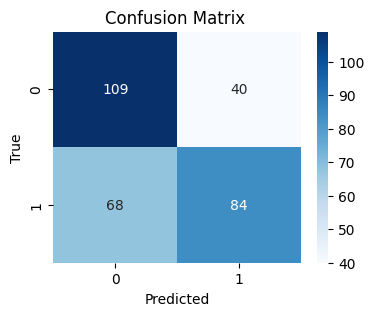

In [544]:
binary_classifiers['KNNeighbors'].fit(X_train, y_train)
y_pred = binary_classifiers['KNNeighbors'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'KNNeighbors', **get_metrics_bin(y_test, y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


precision: 0.675
recall: 0.7105263157894737
f1: 0.6923076923076923
Confusion Matrix and Metrics: 


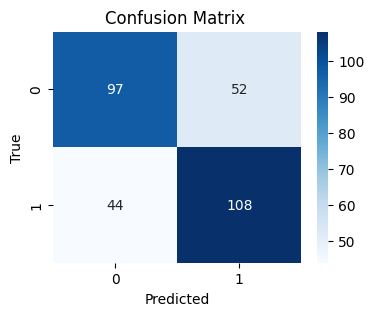

In [545]:
binary_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = binary_classifiers['RandomForest'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'RandomForest', **get_metrics_bin(y_test, y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


precision: 0.611764705882353
recall: 0.6842105263157895
f1: 0.6459627329192548
Confusion Matrix and Metrics: 


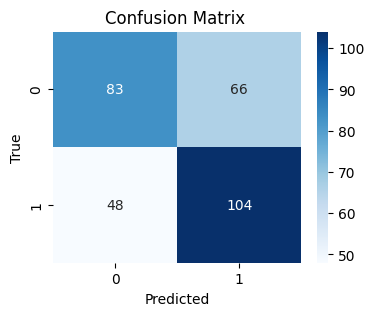

In [546]:
binary_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = binary_classifiers['LogisticRegression'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'LogisticRegression', **get_metrics_bin(y_test, y_pred)}

precision: 0.6273291925465838
recall: 0.6644736842105263
f1: 0.6453674121405751
Confusion Matrix and Metrics: 


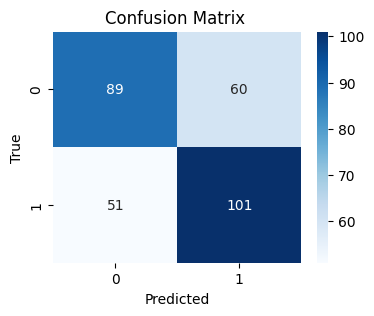

In [547]:
binary_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = binary_classifiers['DecisionTree'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'DecisionTree', **get_metrics_bin(y_test, y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


precision: 0.6387096774193548
recall: 0.6513157894736842
f1: 0.6449511400651465
Confusion Matrix and Metrics: 


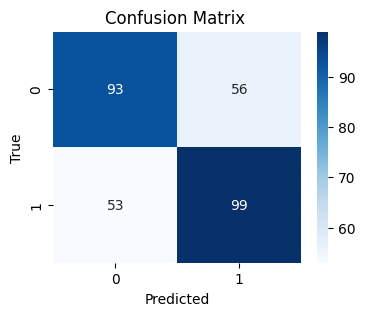

In [548]:
binary_classifiers['LinearDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = binary_classifiers['LinearDiscriminantAnalysis'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'LinearDiscriminantAnalysis', **get_metrics_bin(y_test, y_pred)}

precision: 0.5
recall: 0.07894736842105263
f1: 0.13636363636363635
Confusion Matrix and Metrics: 


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


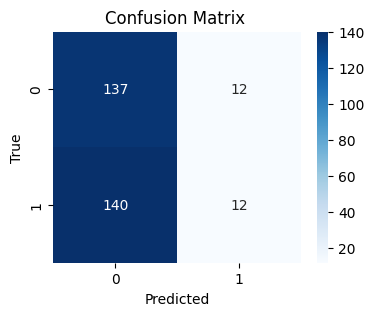

In [549]:
binary_classifiers['QuadraticDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = binary_classifiers['QuadraticDiscriminantAnalysis'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'QuadraticDiscriminantAnalysis', **get_metrics_bin(y_test, y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


precision: 0.5203252032520326
recall: 0.42105263157894735
f1: 0.46545454545454545
Confusion Matrix and Metrics: 


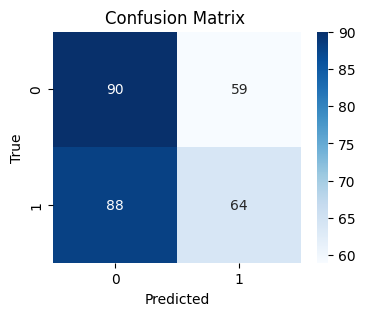

In [550]:
binary_classifiers['SVC'].fit(X_train, y_train)
y_pred = binary_classifiers['SVC'].predict(X_test)
print_metrics_bin(y_test, y_pred)
df_results.loc[len(df_results)] = {'classifier': 'SVC', **get_metrics_bin(y_test, y_pred)}

In [551]:
df_results

,classifier,precision,recall,f1
0,KNNeighbors,0.677419,0.552632,0.608696
1,RandomForest,0.675000,0.710526,0.692308
2,LogisticRegression,0.611765,0.684211,0.645963
3,DecisionTree,0.627329,0.664474,0.645367
4,LinearDiscriminantAnalysis,0.638710,0.651316,0.644951
5,QuadraticDiscriminantAnalysis,0.500000,0.078947,0.136364
6,SVC,0.520325,0.421053,0.465455


## One class classification

O objetivo dessa seção é usar a estratégia de One class classification para tentar classificar os doentes/saudáveis e a identificar as pessoas que tem a doença LBBB ou não.

### Doente ou não

In [552]:
y_binary

,isHealthy
0,False
1,False
2,False
3,False
4,True
...,...
4390,False
4391,False
4392,False
4393,False


Foram testados 4 algoritmos para esse problema: SVM, Isolation Forest, Minimum Covariance Determinant e Local Outlier Factor. Além disso, para cada um desses algorimos considerou-se duas situações: uma em que a classe de doentes é a classe 'inlier' e, portanto, a classe de saudáveis é a 'outlier' e a situação simétrica a essa.

#### SVM

#####
saudável -> outlier\
doente -> inlier

f1: 0.744
              precision    recall  f1-score   support

          -1       0.20      0.35      0.26       167
           1       0.82      0.68      0.74       712

    accuracy                           0.62       879
   macro avg       0.51      0.51      0.50       879
weighted avg       0.70      0.62      0.65       879



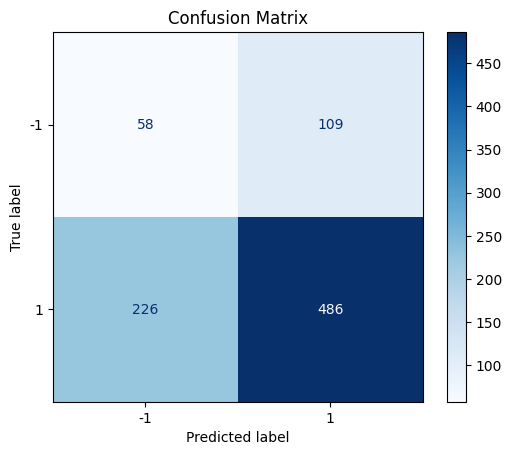

In [553]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_binary.astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel = 'linear', gamma='auto', nu=0.5)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 é saudável
y_test_one_class[y_test_one_class == 0] = 1 # 1 é doente  
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica doente -1 indica saudáveis. Percebe-se que, em geral, o classificador tem mais facilidade em acertar pessoas doentes do que as pessoas saudáveis.

##### 
saudável -> inlier\
doente -> outlier

f1: 0.356
              precision    recall  f1-score   support

          -1       0.86      0.64      0.74       712
           1       0.26      0.54      0.36       167

    accuracy                           0.63       879
   macro avg       0.56      0.59      0.55       879
weighted avg       0.75      0.63      0.66       879



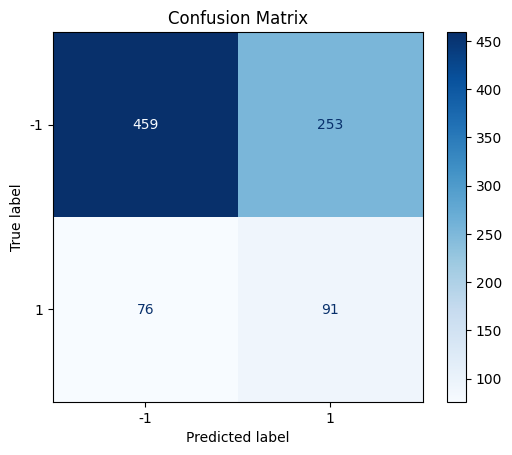

In [554]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel = 'linear', gamma='auto', nu=0.5)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica doente -1 indica saudáveis. Percebe-se que, em geral, o classificador tem mais facilidade em acertar pessoas doentes do que as pessoas saudáveis.

#### Isolation Forest

#####
saudável -> outlier\
doente -> inlier

f1: 0.848
              precision    recall  f1-score   support

          -1       0.10      0.05      0.07       167
           1       0.80      0.90      0.85       712

    accuracy                           0.74       879
   macro avg       0.45      0.47      0.46       879
weighted avg       0.67      0.74      0.70       879



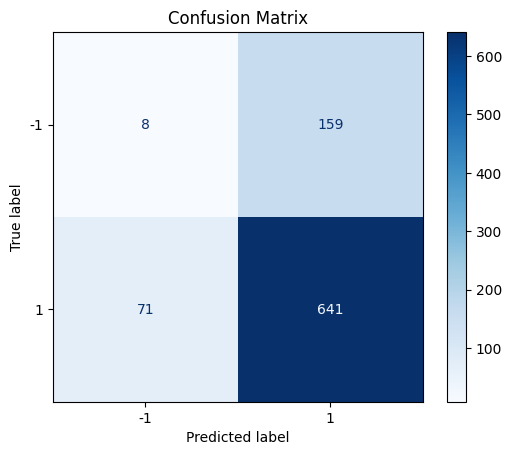

In [555]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica doente -1 indica saudáveis. Percebe-se que, em geral, o classificador tem mais facilidade em acertar pessoas doentes do que as pessoas saudáveis.

#####
saudável -> inlier\
doente -> outlier

f1: 0.335
              precision    recall  f1-score   support

          -1       0.90      0.15      0.25       712
           1       0.20      0.93      0.34       167

    accuracy                           0.30       879
   macro avg       0.55      0.54      0.29       879
weighted avg       0.77      0.30      0.27       879



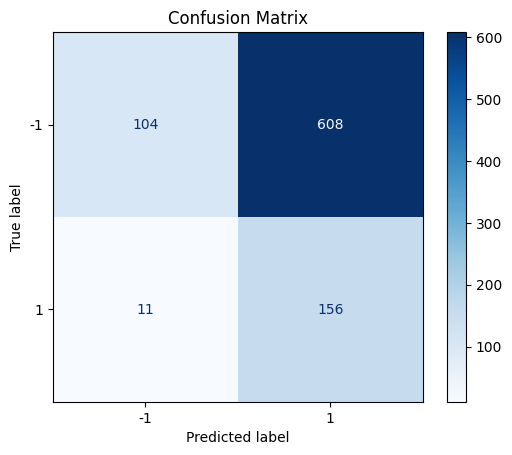

In [556]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica saudáveis -1 indica doentes.

#### Minimum Covariance Determinant

#####
saudável -> outlier\
doente -> inlier

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


f1: 0.609
              precision    recall  f1-score   support

          -1       0.17      0.43      0.24       167
           1       0.79      0.50      0.61       712

    accuracy                           0.48       879
   macro avg       0.48      0.46      0.42       879
weighted avg       0.67      0.48      0.54       879



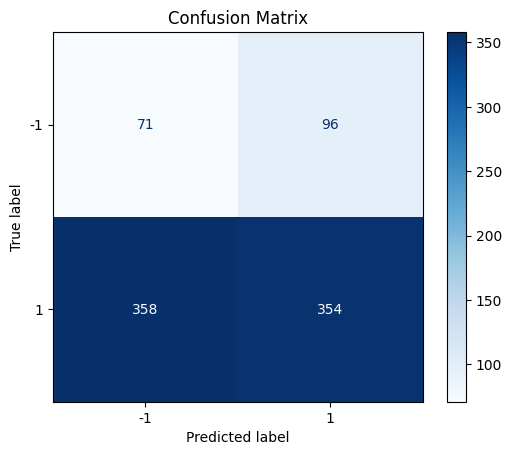

In [557]:
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report


#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_binary.astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 é saudável
y_test_one_class[y_test_one_class == 0] = 1 # 1 é doente  
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica doentes -1 indica saudáveis.

#####
saudável -> inlier\
doente -> outlier

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


f1: 0.318
              precision    recall  f1-score   support

          -1       0.84      0.63      0.72       712
           1       0.24      0.49      0.32       167

    accuracy                           0.61       879
   macro avg       0.54      0.56      0.52       879
weighted avg       0.73      0.61      0.65       879



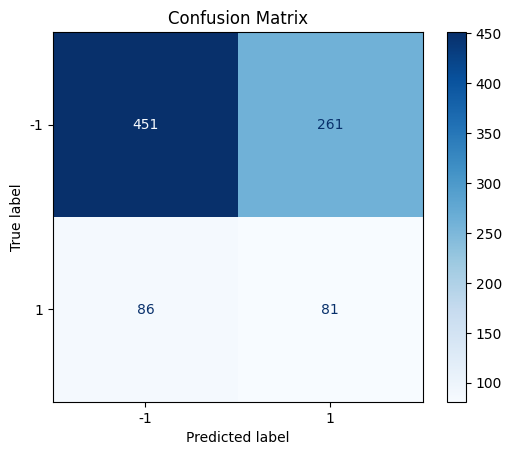

In [558]:
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica saudáveis -1 indica doentes.

#### Local Outlier Factor

#####
saudável -> outlier\
doente -> inlier

In [559]:
def lot_predict(one_class_classifier, X_train_one_class, X_test_one_class):
    # create one large dataset
    composite = np.vstack((X_train_one_class, X_test_one_class))
    # make prediction on composite dataset
    y_pred_one_class = one_class_classifier.fit_predict(composite)
    # return just the predictions on the test set
    return y_pred_one_class[len(X_train_one_class):]

f1: 0.892
              precision    recall  f1-score   support

          -1       0.36      0.02      0.04       167
           1       0.81      0.99      0.89       712

    accuracy                           0.81       879
   macro avg       0.59      0.51      0.47       879
weighted avg       0.73      0.81      0.73       879



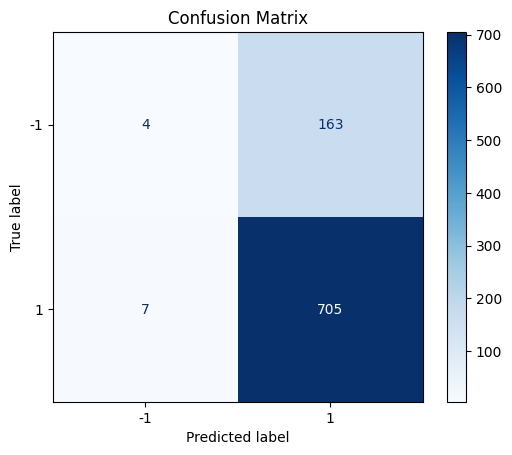

In [560]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X,  (y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0]
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 é saudável
y_test_one_class[y_test_one_class == 0] = 1 # 1 é doente  
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica doentes -1 indica saudáveis.

#####
saudável -> inlier\
doente -> outlier

f1: 0.316
              precision    recall  f1-score   support

          -1       0.62      0.01      0.01       712
           1       0.19      0.98      0.32       167

    accuracy                           0.19       879
   macro avg       0.41      0.49      0.16       879
weighted avg       0.54      0.19      0.07       879



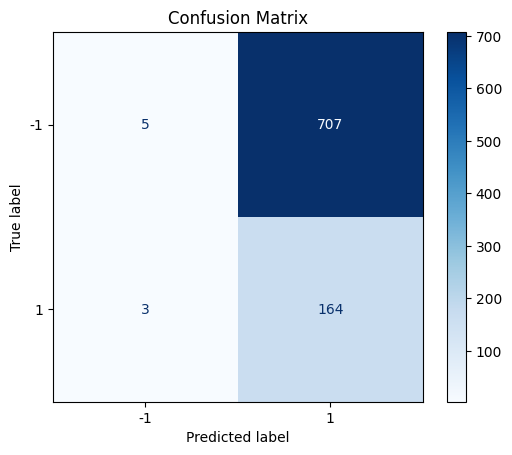

In [561]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X,  (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0]
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### LBBB

Foram testados 4 algoritmos para esse problema: SVM, Isolation Forest, Minimum Covariance Determinant e Local Outlier Factor. Além disso, para cada um desses algorimos considerou-se duas situações: uma em que a classe LBBB é a classe 'inlier' e, portanto, a classe 'não-LBBB' é a 'outlier' e a situação simétrica a essa.

#### SVM

##### 
LBB -> outlier\
não-LBBB -> inlier

f1: 0.650
              precision    recall  f1-score   support

          -1       0.26      0.96      0.41       140
           1       0.99      0.48      0.65       739

    accuracy                           0.56       879
   macro avg       0.62      0.72      0.53       879
weighted avg       0.87      0.56      0.61       879



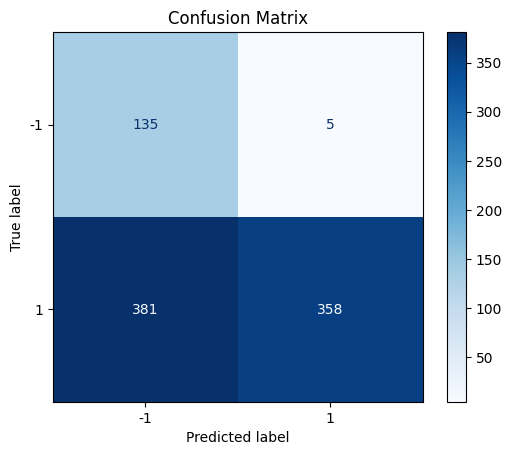

In [562]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel = 'linear', gamma='scale', nu=0.5)
# Selecionando só as amostras negativas
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # LBBB
y_test_one_class[y_test_one_class == 0] = 1  # não LBBB
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

##### 
LBB -> inlier\
não-LBBB -> outlier

f1: 0.020
              precision    recall  f1-score   support

          -1       0.74      0.52      0.61       739
           1       0.01      0.04      0.02       140

    accuracy                           0.44       879
   macro avg       0.38      0.28      0.31       879
weighted avg       0.62      0.44      0.51       879



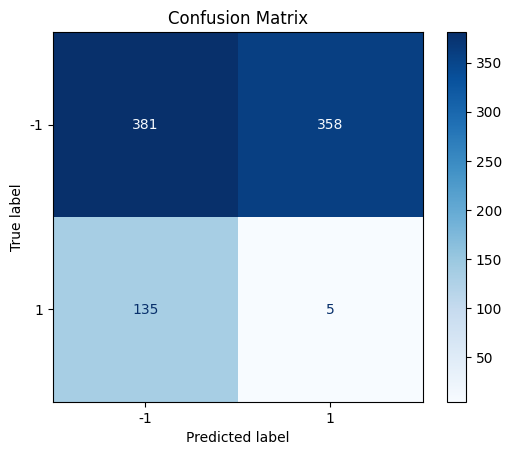

In [563]:
# Agora as amostras que não apresentam LBBB são os inliers e os que apresentam são outliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel='linear' , gamma='auto', nu=0.5)
# Selecionando só as amostras positivas
X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1  # LBBB
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem

#### Isolation Forest

##### 
LBB -> outlier\
não-LBBB -> inlier

f1: 0.898
              precision    recall  f1-score   support

          -1       0.44      0.36      0.39       140
           1       0.88      0.91      0.90       739

    accuracy                           0.82       879
   macro avg       0.66      0.64      0.65       879
weighted avg       0.81      0.82      0.82       879



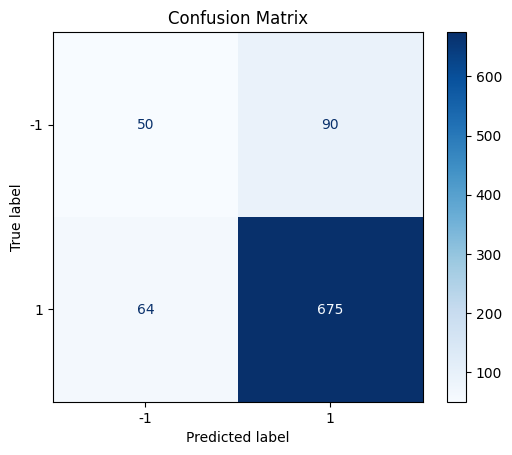

In [564]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # LBBB
y_test_one_class[y_test_one_class == 0] = 1 # não LBBB
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

##### 
LBB -> inlier\
não-LBBB -> outlier

f1: 0.209
              precision    recall  f1-score   support

          -1       0.53      0.07      0.12       739
           1       0.12      0.69      0.21       140

    accuracy                           0.17       879
   macro avg       0.33      0.38      0.16       879
weighted avg       0.47      0.17      0.13       879



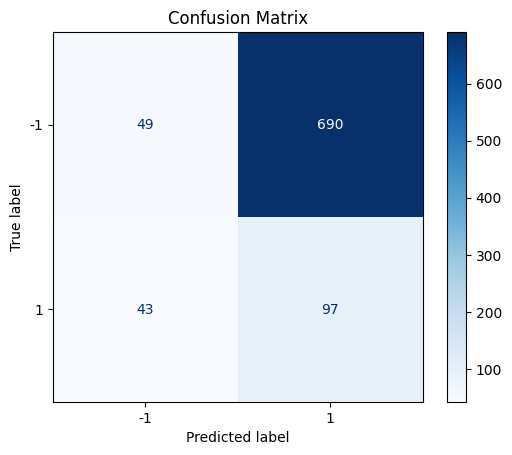

In [565]:
# Agora as amostras que não apresentam LBBB são os outliers e os que apresentam são inliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras positivas (LBBB)
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1  # LBBB
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem

#### Minimum Covariance Determinant

##### 
LBB -> outlier\
não-LBBB -> inlier

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


f1: 0.651
              precision    recall  f1-score   support

          -1       0.24      0.84      0.37       140
           1       0.94      0.50      0.65       739

    accuracy                           0.55       879
   macro avg       0.59      0.67      0.51       879
weighted avg       0.83      0.55      0.61       879



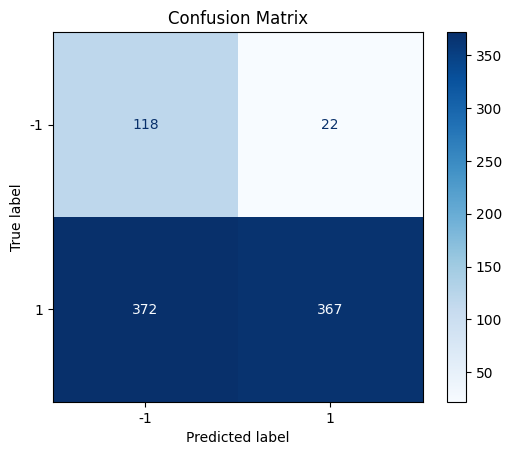

In [566]:
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

##### 
LBB -> inlier\
não-LBBB -> outlier

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


f1: 0.103
              precision    recall  f1-score   support

          -1       0.75      0.44      0.55       739
           1       0.07      0.21      0.10       140

    accuracy                           0.40       879
   macro avg       0.41      0.33      0.33       879
weighted avg       0.64      0.40      0.48       879



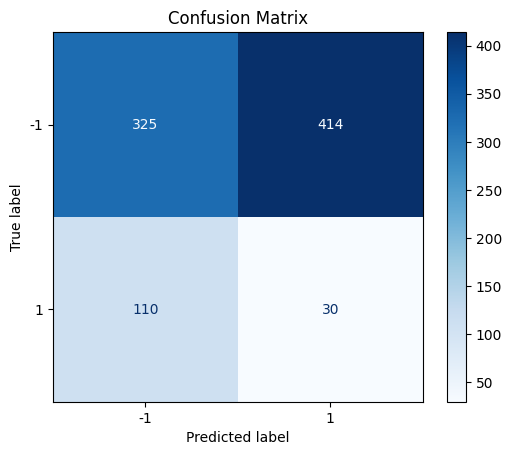

In [567]:
# Agora as amostras que não apresentam LBBB são os outliers e os que apresentam são inliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras positivas (LBBB)
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1  # LBBB 
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem

#### Local Outlier Factor

##### 
LBB -> outlier\
não-LBBB -> inlier

f1: 0.909
              precision    recall  f1-score   support

          -1       0.11      0.01      0.01       140
           1       0.84      0.99      0.91       739

    accuracy                           0.83       879
   macro avg       0.48      0.50      0.46       879
weighted avg       0.72      0.83      0.77       879



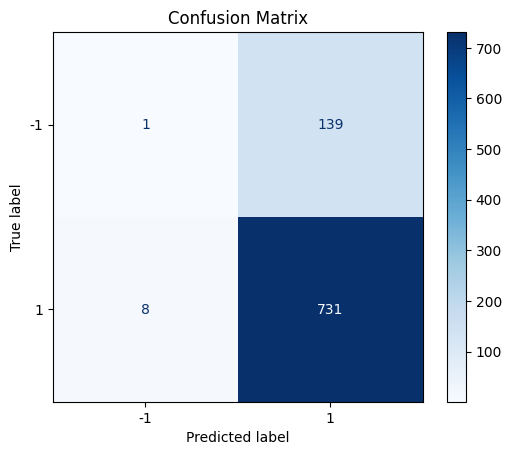

In [568]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

def lot_predict(one_class_classifier, X_train_one_class, X_test_one_class):
    # create one large dataset
    composite = np.vstack((X_train_one_class, X_test_one_class))
    # make prediction on composite dataset
    y_pred_one_class = one_class_classifier.fit_predict(composite)
    # return just the predictions on the test set
    return y_pred_one_class[len(X_train_one_class):]

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


1 indica aquelas amostras que não pertencem à classe LBBB, e -1 indicam aqueles que pertencem

##### 
LBB -> inlier\
não-LBBB -> outlier

f1: 0.276
              precision    recall  f1-score   support

          -1       0.90      0.01      0.02       739
           1       0.16      0.99      0.28       140

    accuracy                           0.17       879
   macro avg       0.53      0.50      0.15       879
weighted avg       0.78      0.17      0.06       879



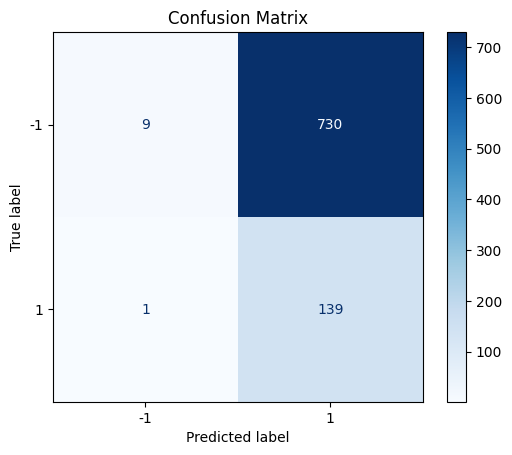

In [569]:
# Agora as amostras que não apresentam LBBB são os inliers e os que apresentam são outliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=25,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 1] 
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1 # LBBB
# Calculando métricas
f1 = f1_score(y_pred_one_class, y_test_one_class)
print(f"f1: {f1:.3f}")
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1 indica amostras que pertencem à classe LBBB e -1 indica aquela que não pertencem.